In [1]:
# %%
# =============================================================================
# Passo 1: Importação de Bibliotecas
# =============================================================================

# Bibliotecas padrão
import csv
import gc
from pathlib import Path

# Bibliotecas de terceiros para análise e manipulação de dados
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import skew, kurtosis, ttest_ind

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de pré-processamento do Scikit-learn
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [2]:
# %%
# =============================================================================
# Passo 2: Carregamento e Concatenação dos Dados
# =============================================================================

# --- Funções de Leitura Robusta (sem alteração) ---
def detectar_delimitador(caminho_arquivo: Path, tamanho_amostra: int = 65536) -> str:
    with caminho_arquivo.open("rb") as f:
        amostra = f.read(tamanho_amostra)
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            texto = amostra.decode(enc, errors="strict")
            dialect = csv.Sniffer().sniff(texto, delimiters=";,")
            return dialect.delimiter
        except Exception:
            continue
    return ";"

def ler_csv_robusto(caminho_arquivo: Path) -> pd.DataFrame:
    sep_detectado = detectar_delimitador(caminho_arquivo)
    encodings = ("utf-8-sig", "utf-8", "latin-1", "cp1252")
    erros = []
    for enc in encodings:
        try:
            # Usar low_memory=False para evitar inferência de tipo por chuncks, prevenindo erros
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, low_memory=False, engine="c")
        except Exception as e:
            erros.append((f"engine=c | {enc}", str(e)))
    
    # Fallback para engine python se o 'c' falhar
    for enc in encodings:
        try:
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            erros.append((f"engine=python | {enc}", str(e)))
            
    msg = f"Falha ao ler {caminho_arquivo.name}. Erros:\\n" + "\\n".join([f" - {ctx}: {err}" for ctx, err in erros])
    raise RuntimeError(msg)



In [3]:
# --- Processo de Leitura e Concatenação ---

# Caminho para a pasta com os arquivos CSV
pasta_csvs = Path.cwd() / "Bases" / "0_RAIS_Bases_Amostra" / "RAIS_Enap_amostra_"
assert pasta_csvs.exists(), f"Pasta não encontrada: {pasta_csvs}"

# Listar e ler os arquivos
arquivos_csv = sorted([p for p in pasta_csvs.glob("*.csv")])
if not arquivos_csv:
    raise FileNotFoundError("Nenhum CSV encontrado na pasta indicada.")

print(f"Arquivos encontrados: {len(arquivos_csv)}")
dataframes = []
for idx, arq in enumerate(arquivos_csv, start=1):
    print(f"[{idx}/{len(arquivos_csv)}] Lendo: {arq.name} ...", end="")
    df_tmp = ler_csv_robusto(arq)
    dataframes.append(df_tmp)
    print(f" ok ({df_tmp.shape[0]} linhas, {df_tmp.shape[1]} colunas)")

# Concatena todos os DataFrames em um só
print("\\nConcatenando DataFrames...")
df = pd.concat(dataframes, ignore_index=True)
print("Dimensão final:", df.shape)



Arquivos encontrados: 11
[1/11] Lendo: RAIS_2014_Enap_amostra.csv ... ok (1128887 linhas, 37 colunas)
[2/11] Lendo: RAIS_2015_Enap_amostra.csv ... ok (1090572 linhas, 37 colunas)
[3/11] Lendo: RAIS_2016_Enap_amostra.csv ... ok (726162 linhas, 37 colunas)
[4/11] Lendo: RAIS_2017_Enap_amostra.csv ... ok (1073850 linhas, 37 colunas)
[5/11] Lendo: RAIS_2018_Enap_amostra.csv ... ok (1082710 linhas, 37 colunas)
[6/11] Lendo: RAIS_2019_Enap_amostra.csv ... ok (796532 linhas, 37 colunas)
[7/11] Lendo: RAIS_2020_Enap_amostra.csv ... ok (1109627 linhas, 37 colunas)
[8/11] Lendo: RAIS_2021_Enap_amostra.csv ... ok (1199769 linhas, 37 colunas)
[9/11] Lendo: RAIS_2022_Enap_amostra.csv ... ok (1245516 linhas, 37 colunas)
[10/11] Lendo: RAIS_2023_Enap_amostra.csv ... ok (1328596 linhas, 37 colunas)
[11/11] Lendo: RAIS_2024_Enap_amostra.csv ... ok (985182 linhas, 37 colunas)
\nConcatenando DataFrames...
Dimensão final: (11767403, 37)


In [4]:
# --- Otimização de Memória ---
# Remove a lista de dataframes e o dataframe temporário da memória
del dataframes
del df_tmp
gc.collect() # Executa o garbage collector para liberar memória
print("Memória liberada.")


Memória liberada.


In [5]:
# %%
# =============================================================================
# Passo 3: Limpeza, Otimização e Transformação dos Dados
# =============================================================================

# --- 3.1: Remoção de Colunas Desnecessárias ---
colunas_para_remover = [
    "VinculoAtivo", "NRMesDesligamento", "TPAdmissao", "TPEstabelecimento", 
    "TPDeficiencia", "CDCausaAfastamento1", "CDCausaAfastamento2", "CDCausaAfastamento3", 
    "INTrabIntermitente", "VLRemunDezembroNom", "VLRemunDezembroSM", "VLSalarioContratual",
    "NRCNPJCEI", "NRCNPJRaiz", "CDCNAE20Subclasse", "Estoque_Total", "Estoque_Fem", "TPSalario"
]
existentes = [c for c in colunas_para_remover if c in df.columns]
df.drop(columns=existentes, inplace=True)
gc.collect()
print(f"Colunas removidas. Shape após remoção: {df.shape}")


Colunas removidas. Shape após remoção: (11767403, 19)


In [6]:

# --- 3.2: Limpeza de Outliers de Remuneração ---
df.dropna(subset=["VLRemunMediaNom"], inplace=True)
df = df[(df["VLRemunMediaSM"] >= 0.3) & (df["VLRemunMediaSM"] <= 150)]
print(f"Shape após limpeza de salários: {df.shape}")


Shape após limpeza de salários: (11357549, 19)


In [7]:

# --- 3.3: Otimização de Tipos de Dados ---
print("Otimizando tipos de dados...")

if 'CDCBOOcupacao2002' in df.columns:
    df['CDCBOOcupacao2002'] = df['CDCBOOcupacao2002'].astype(str)

colunas_categoricas = [
    "NRANO", 
    "CDDesligamento", "CDGrauEscolaridade", "CDNaturezaJuridica", "CDRacaCor", 
    "CDSexo", "CDTamanhoEstabelecimento", "INPortadorDefic", "INTrabParcial", 
    "TPVinculo", "CDCNAE20Classe", "CDMunicipio"
]


Otimizando tipos de dados...


In [8]:

# --- 3.4: Criação de Novas Colunas (Engenharia de Features) ---
print("Criando novas colunas...")
ocupacoes_map = {
    '0': 'FORÇAS ARMADAS, POLICIAIS E BOMBEIROS', '1': 'DIRIGENTES E GERENTES',
    '2': 'PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES', '3': 'TÉCNICOS DE NÍVEL MÉDIO', 
    '4': 'TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS', '5': 'TRABALHADORES DOS SERVIÇOS E VENDEDORES',
    '6': 'TRABALHADORES AGROPECUÁRIOS E DA PESCA', '7': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL',
    '8': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL', '9': 'TRABALHADORES DE REPARAÇÃO E MANUTENÇÃO'
}
df['GrupoOcupacao'] = df['CDCBOOcupacao2002'].str[0].map(ocupacoes_map).astype("category")


Criando novas colunas...


In [9]:

# --- 3.5: Filtragem por Capitais ---
print("Filtrando registros apenas das capitais...")
codigos_capitais = [
    431490, 330455, 520870, 355030, 250750, 261160, 221100, 292740, 510340, 150140, 
    410690, 270430, 230440, 240810, 280030, 110020, 120040, 130260, 500270, 310620, 
    421660, 172100, 160060, 211130, 320530, 530010
]
df['CDMunicipio'] = pd.to_numeric(df['CDMunicipio'], errors='coerce').astype('Int64')
df = df[df['CDMunicipio'].isin(codigos_capitais)].copy()


Filtrando registros apenas das capitais...


In [10]:
# --- Limpeza Final de Memória ---
gc.collect()
print(f"Pré-processamento concluído. Shape final para análise: {df.shape}")

Pré-processamento concluído. Shape final para análise: (4257681, 20)


In [11]:
# %%
# =============================================================================
# Passo 4: Análise Exploratória e Normalização da Remuneração
# =============================================================================

# --- 4.1: Análise Univariada da Remuneração (Pós-filtro) ---
s = df["VLRemunMediaNom"]
print("Resumo estatístico da Remuneração (Pós-filtro):")
display(s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).round(2))


Resumo estatístico da Remuneração (Pós-filtro):


count    4257681.00
mean        4430.63
std         6556.31
min          217.20
1%           581.16
5%           914.00
25%         1460.60
50%         2222.44
75%         4463.25
95%        15583.52
99%        32883.11
max       209000.00
Name: VLRemunMediaNom, dtype: float64

In [12]:

# --- 4.2: DataFrame para testes de normalização ---
df_norm = df[['VLRemunMediaNom']].copy()


# Aplica as transformações
df_norm['log_VLRemunMediaNom'] = np.log1p(df_norm['VLRemunMediaNom'])
df_norm['robust_VLRemunMediaNom'] = RobustScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['std_VLRemunMediaNom'] = StandardScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['minmax_VLRemunMediaNom'] = MinMaxScaler().fit_transform(df_norm[['VLRemunMediaNom']])
df_norm['yeoj_VLRemunMediaNom'] = PowerTransformer(method='yeo-johnson').fit_transform(df_norm[['VLRemunMediaNom']])

In [13]:
# --- 4.3: Avaliação de Assimetria e Curtose ---
print("\n📊 Skew e Curtose das transformações:")
for col in df_norm.columns:
    skew_val = skew(df_norm[col].dropna())
    kurt_val = kurtosis(df_norm[col].dropna())
    print(f"{col:<30} | Skew: {skew_val:>7.3f} | Kurtosis: {kurt_val:>7.3f}")



📊 Skew e Curtose das transformações:
VLRemunMediaNom                | Skew:   5.939 | Kurtosis:  69.292
log_VLRemunMediaNom            | Skew:   0.861 | Kurtosis:   0.508
robust_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
std_VLRemunMediaNom            | Skew:   5.939 | Kurtosis:  69.292
minmax_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
yeoj_VLRemunMediaNom           | Skew:   0.038 | Kurtosis:  -0.101


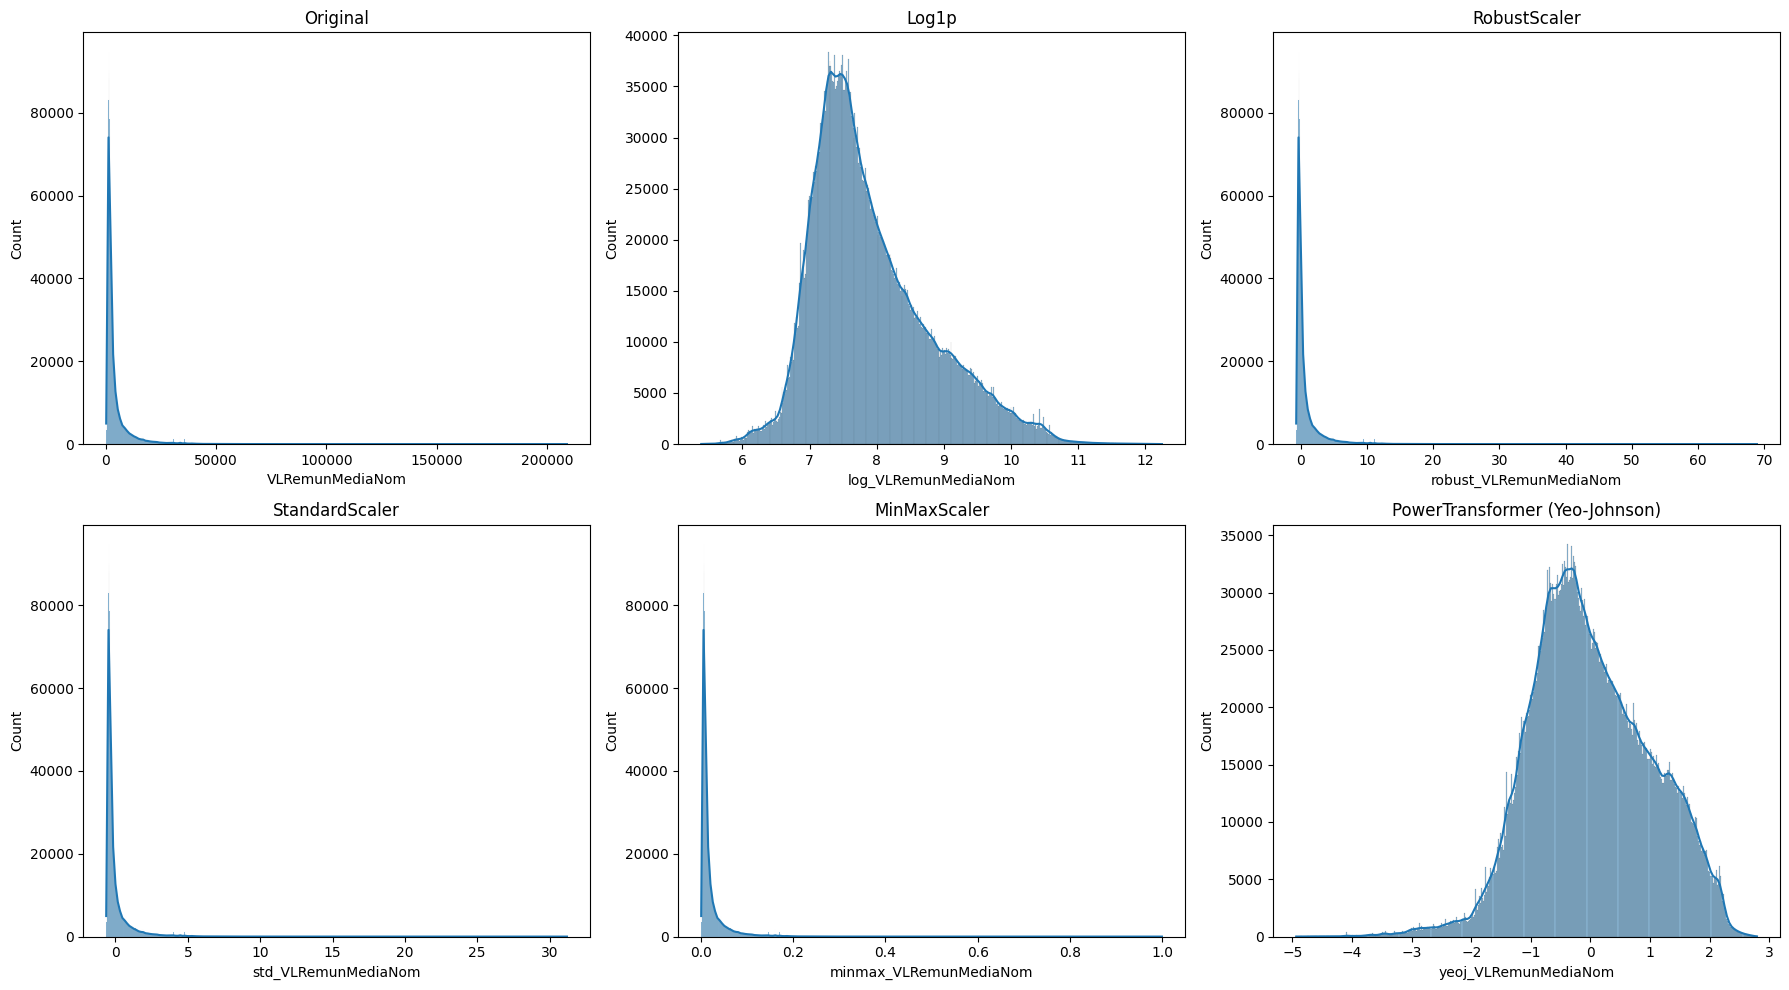

In [14]:

# --- 4.4: Visualização das Distribuições ---
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
sns.histplot(df_norm['VLRemunMediaNom'], ax=axs[0, 0], kde=True).set(title='Original')
sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0, 1], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0, 2], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[1, 0], kde=True).set(title='StandardScaler')
sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1, 1], kde=True).set(title='MinMaxScaler')
sns.histplot(df_norm['yeoj_VLRemunMediaNom'], ax=axs[1, 2], kde=True).set(title='PowerTransformer (Yeo-Johnson)')
plt.tight_layout()
plt.show()

In [15]:
# %%
# =============================================================================
# Passo 5: Análise de Carga Horária e Remuneração por Sexo
# =============================================================================

# --- 5.1: Preparação do DataFrame ---
# Mapeamos o sexo para melhor legibilidade no DataFrame principal
df['CDSexo'] = df['CDSexo'].map({1.0: 'Masculino', 2.0: 'Feminino'}).astype("category")

# Criamos uma cópia específica para a análise de horas, removendo nulos
df_horas = df.dropna(subset=['NRQtdHoraContr', 'CDSexo', 'GrupoOcupacao']).copy()

In [16]:
# --- 5.2: Análise da Carga Horária por Sexo (Geral) ---
print("--- Análise Geral por Sexo ---")
display(df_horas.groupby('CDSexo', observed=False)['NRQtdHoraContr'].describe())

# Separação por sexo para o teste-t
homens = df_horas[df_horas['CDSexo'] == 'Masculino']['NRQtdHoraContr']
mulheres = df_horas[df_horas['CDSexo'] == 'Feminino']['NRQtdHoraContr']
t_stat, p_valor = ttest_ind(homens, mulheres, equal_var=False)
print(f"\nEstatística t (Geral) = {t_stat:.3f} | p-valor = {p_valor:.4f}")

--- Análise Geral por Sexo ---


,count,mean,std,min,25%,50%,75%,max
CDSexo,,,,,,,,
Feminino,1911896.0,39.046746,8.859614,0.0,36.0,40.0,44.0,99.0
Masculino,2345784.0,40.928552,8.737053,0.0,40.0,44.0,44.0,99.0



Estatística t (Geral) = 219.354 | p-valor = 0.0000


In [17]:
# --- 5.3: Análise da Carga Horária por Grupo Ocupacional e Sexo ---
print("\n--- Análise por Grupo Ocupacional e Sexo ---")
grupo_sexo_stats = (
    df_horas.groupby(['GrupoOcupacao', 'CDSexo'], observed=False)['NRQtdHoraContr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
)
display(grupo_sexo_stats)


--- Análise por Grupo Ocupacional e Sexo ---


,GrupoOcupacao,CDSexo,count,mean,std
0,DIRIGENTES E GERENTES,Feminino,115970,39.475520,11.749788
1,DIRIGENTES E GERENTES,Masculino,141401,39.997383,11.954777
2,"FORÇAS ARMADAS, POLICIAIS E BOMBEIROS",Feminino,5478,39.803578,1.912675
3,"FORÇAS ARMADAS, POLICIAIS E BOMBEIROS",Masculino,21676,39.709587,1.806675
4,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES,Feminino,318087,35.979113,11.769197
5,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES,Masculino,288022,36.753238,12.849189
6,TRABALHADORES AGROPECUÁRIOS E DA PESCA,Feminino,2323,42.203616,3.488056
7,TRABALHADORES AGROPECUÁRIOS E DA PESCA,Masculino,15148,42.858265,4.580614
8,TRABALHADORES DA PRODUÇÃO INDUSTRIAL,Feminino,72545,44.453250,9.899055
9,TRABALHADORES DA PRODUÇÃO INDUSTRIAL,Masculino,505060,43.369871,7.473455


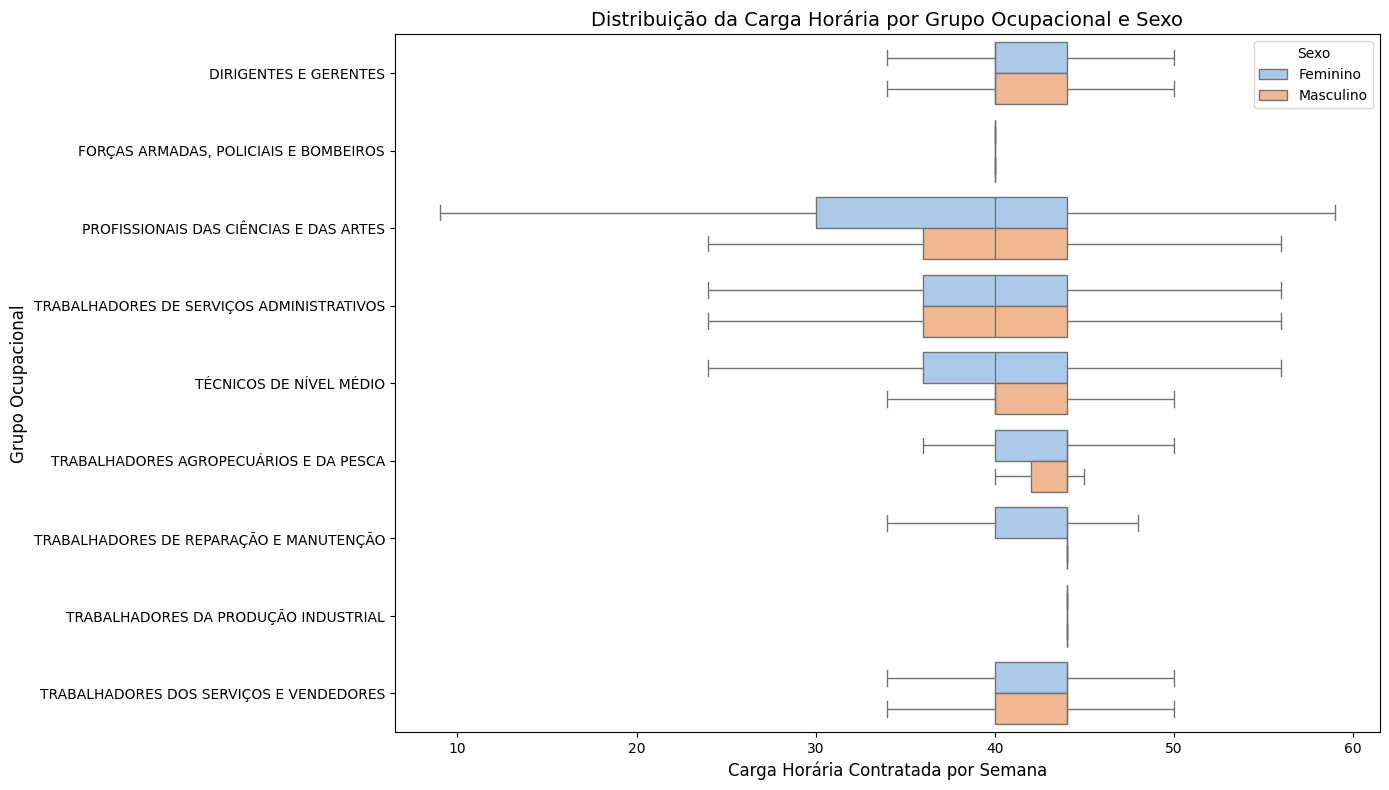

In [18]:
# --- 5.4: Visualização com Boxplot ---
# Ordena os grupos pela mediana da carga horária para melhor visualização
medianas = df_horas.groupby("GrupoOcupacao", observed=False)["NRQtdHoraContr"].median().sort_values()
ordem = medianas.index.tolist()

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_horas, y='GrupoOcupacao', x='NRQtdHoraContr', hue='CDSexo',
    orient='h', order=ordem, showfliers=False, palette='pastel'
)
plt.title('Distribuição da Carga Horária por Grupo Ocupacional e Sexo', fontsize=14)
plt.xlabel('Carga Horária Contratada por Semana', fontsize=12)
plt.ylabel('Grupo Ocupacional', fontsize=12)
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

In [19]:
# --- 5.5: Salvar o DataFrame final e limpo (Opcional) ---
# Adicionando a coluna de log da remuneração antes de salvar
df['log_VLRemunMediaNom'] = np.log1p(df['VLRemunMediaNom'])
saida_final_parquet = pasta_csvs / "RAIS_CAPITAIS_PROCESSADO_FINAL.parquet"
df.to_parquet(saida_final_parquet, index=False)

print(f"\nDataFrame final salvo com sucesso em: {saida_final_parquet}")


DataFrame final salvo com sucesso em: C:\Users\Guilherme\OneDrive\Cursos\ENAP\MBA em Inteligência Artificial\Disciplinas\18 - Lab 02\Bases\0_RAIS_Bases_Amostra\RAIS_Enap_amostra_\RAIS_CAPITAIS_PROCESSADO_FINAL.parquet


--- Análise da Remuneração Média por Sexo e Ano ---


CDSexo,Feminino,Masculino
NRANO,,
2014,3113.992563,3584.180238
2015,3395.443606,3982.008113
2016,3646.241496,4231.137202
2017,3828.504941,4488.850097
2018,3845.329824,4625.906958
2019,4214.726907,4901.937472
2020,4025.025277,4843.982076
2021,4127.284933,4981.466749
2022,4954.314613,5900.164003


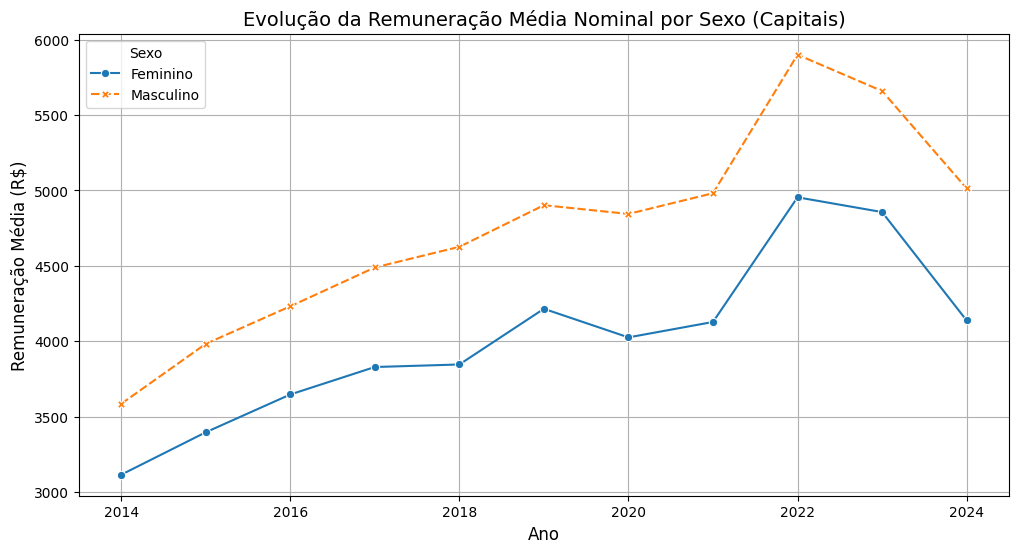

In [20]:
# %%
# =============================================================================
# Passo 6: Análise de Remuneração por Sexo e Ano
# =============================================================================

# Garante que a coluna de ano seja do tipo 'category' para a análise
df['NRANO'] = df['NRANO'].astype('category')

# --- 6.1: Análise da Remuneração Média por Sexo e Ano ---
print("--- Análise da Remuneração Média por Sexo e Ano ---")
df_remun = df.dropna(subset=['VLRemunMediaNom', 'CDSexo'])

# Agrupa por ano e sexo para ver a evolução
remuneracao_anual = df_remun.groupby(['NRANO', 'CDSexo'], observed=False)['VLRemunMediaNom'].mean().unstack()
display(remuneracao_anual)

# Gráfico de linhas para visualizar a tendência
plt.figure(figsize=(12, 6))
sns.lineplot(data=remuneracao_anual, markers=True)
plt.title('Evolução da Remuneração Média Nominal por Sexo (Capitais)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Remuneração Média (R$)', fontsize=12)
plt.legend(title='Sexo')
plt.grid(True)
plt.show()

In [21]:
# %%
# --- 6.2: Teste de Significância Estatística para a Diferença Salarial ---
print("\n--- Teste-t para a Diferença Salarial por Ano ---")

resultados_teste_t_salario = []
anos = df_remun['NRANO'].unique().sort_values()

for ano in anos:
    dados_ano = df_remun[df_remun['NRANO'] == ano]
    
    salarios_homens = dados_ano[dados_ano['CDSexo'] == 'Masculino']['VLRemunMediaNom']
    salarios_mulheres = dados_ano[dados_ano['CDSexo'] == 'Feminino']['VLRemunMediaNom']
    
    if len(salarios_homens) > 1 and len(salarios_mulheres) > 1:
        # Usamos o log da remuneração para o teste, pois tem uma distribuição mais próxima da normal
        t_stat, p_val = ttest_ind(np.log1p(salarios_homens), np.log1p(salarios_mulheres), equal_var=False)
        
        resultados_teste_t_salario.append({
            'Ano': ano,
            'Media_Salario_Masc': salarios_homens.mean(),
            'Media_Salario_Fem': salarios_mulheres.mean(),
            'Diferenca_Absoluta': salarios_homens.mean() - salarios_mulheres.mean(),
            'Diferenca_Percentual': (salarios_homens.mean() - salarios_mulheres.mean()) / salarios_homens.mean() * 100,
            'p_valor': p_val
        })

df_teste_t_salario = pd.DataFrame(resultados_teste_t_salario)
display(df_teste_t_salario.round(2))


--- Teste-t para a Diferença Salarial por Ano ---


,Ano,Media_Salario_Masc,Media_Salario_Fem,Diferenca_Absoluta,Diferenca_Percentual,p_valor
0,2014,3584.18,3113.99,470.19,13.12,0.0
1,2015,3982.01,3395.44,586.56,14.73,0.0
2,2016,4231.14,3646.24,584.90,13.82,0.0
3,2017,4488.85,3828.50,660.35,14.71,0.0
4,2018,4625.91,3845.33,780.58,16.87,0.0
5,2019,4901.94,4214.73,687.21,14.02,0.0
6,2020,4843.98,4025.03,818.96,16.91,0.0
7,2021,4981.47,4127.28,854.18,17.15,0.0
8,2022,5900.16,4954.31,945.85,16.03,0.0
9,2023,5659.44,4856.33,803.11,14.19,0.0


# Teste de hipóteses

In [22]:
# %%
# =============================================================================
# Passo 6: Teste-t por Grupo Ocupacional (Análise Reincorporada)
# =============================================================================
# Esta análise verifica se a diferença de carga horária entre os sexos é 
# estatisticamente significativa dentro de cada grupo ocupacional.

print("--- Teste-t por Grupo Ocupacional ---")
resultados_teste_t = []
for grupo in df_horas['GrupoOcupacao'].dropna().unique():
    sub = df_horas[df_horas['GrupoOcupacao'] == grupo]
    fem = sub[sub['CDSexo'] == 'Feminino']['NRQtdHoraContr']
    masc = sub[sub['CDSexo'] == 'Masculino']['NRQtdHoraContr']
    
    # Realiza o teste apenas se houver amostras para ambos os sexos
    if len(fem) > 1 and len(masc) > 1:
        t_stat, p_val = ttest_ind(masc, fem, equal_var=False)
        resultados_teste_t.append({
            'GrupoOcupacao': grupo,
            'Media_Masc': masc.mean(),
            'Media_Fem': fem.mean(),
            'Dif_Medias': masc.mean() - fem.mean(),
            't_stat': t_stat,
            'p_valor': p_val
        })

df_teste_t = pd.DataFrame(resultados_teste_t)
display(df_teste_t)

# --- Limpeza final da memória, agora sim no final de todo o script ---
del df, df_norm, df_horas
gc.collect()
print("\nAnálise concluída e memória liberada.")

--- Teste-t por Grupo Ocupacional ---


,GrupoOcupacao,Media_Masc,Media_Fem,Dif_Medias,t_stat,p_valor
0,DIRIGENTES E GERENTES,39.997383,39.475520,0.521864,11.123196,9.826381e-29
1,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,39.252320,38.636629,0.615691,40.547010,0.000000e+00
2,TRABALHADORES DA PRODUÇÃO INDUSTRIAL,43.369871,44.453250,-1.083379,-28.340206,7.344799e-176
3,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES,36.753238,35.979113,0.774125,24.374360,3.720969e-131
4,TRABALHADORES DOS SERVIÇOS E VENDEDORES,42.162287,41.345368,0.816919,59.680398,0.000000e+00
5,TRABALHADORES DE REPARAÇÃO E MANUTENÇÃO,42.626604,41.470986,1.155618,8.875899,8.870745e-19
6,TRABALHADORES AGROPECUÁRIOS E DA PESCA,42.858265,42.203616,0.654649,8.044438,1.158359e-15
7,TÉCNICOS DE NÍVEL MÉDIO,40.321566,38.195254,2.126312,105.798617,0.000000e+00
8,"FORÇAS ARMADAS, POLICIAIS E BOMBEIROS",39.709587,39.803578,-0.093991,-3.285513,1.022283e-03



Análise concluída e memória liberada.
